In [28]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F


## Load Data

In [ ]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

# Define paths
path_to_data = "../../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

In [7]:
df = load_data(path_to_training_tweets)
print(df)

           ID  MatchID  PeriodID  EventType      Timestamp  \
0        11_0       11         0          0  1404575400000   
1        11_0       11         0          0  1404575400000   
2        11_0       11         0          0  1404575400000   
3        11_0       11         0          0  1404575400000   
4        11_0       11         0          0  1404575400000   
...       ...      ...       ...        ...            ...   
272384  3_129        3       129          1  1403805600000   
272385  3_129        3       129          1  1403805600000   
272386  3_129        3       129          1  1403805600000   
272387  3_129        3       129          1  1403805600000   
272388  3_129        3       129          1  1403805600000   

                                                    Tweet  
0       RT @2014WorIdCup: Argentina vs Belgium\n\nWho ...  
1       @elijahman_ time to focus on Belgium winning t...  
2       RT @FIFAWorldCup: GLOBAL STADIUM: #Joinin with...  
3       RT @Cat

In [12]:
MAX_SUBGROUPS = 150
df["random_id"] = np.random.randint(0, MAX_SUBGROUPS, len(df))
df_bis = df.groupby(["random_id", "ID", "PeriodID", "EventType", "MatchID"])["Tweet"].apply(lambda x: " ".join(x)).reset_index().drop("random_id",axis=1)
df_bis = df_bis.sample(frac=1).reset_index(drop=True)
print(df_bis)

           ID  PeriodID  EventType  MatchID  \
0        2_46        46          1        2   
1       17_56        56          1       17   
2        7_13        13          0        7   
3       13_91        91          1       13   
4       12_72        72          0       12   
...       ...       ...        ...      ...   
311568   2_98        98          1        2   
311569   5_28        28          1        5   
311570   8_43        43          1        8   
311571    5_0         0          0        5   
311572  7_100       100          0        7   

                                                    Tweet  
0       RT @FIFAWorldCup: GOAL: #AUS 0-1 #ESP @Guaje7V...  
1       RT @CRonaldoNews: Boye is the best player from...  
2       RT @PeteBuglioni: Prediction - #CHI 2-1 #NED R...  
3       Nigeria is actually playing pretty good right ...  
4       RT @9GAG: How does he do that? http://t.co/621...  
...                                                   ...  
311568  RT @Fut

# Preprocessing

In [ ]:
def preprocessing(df):
    df["Tweet"] = df["Tweet"].str.lower()
    return df

In [14]:
preprocessing(df_bis)
print(df_bis)

           ID  PeriodID  EventType  MatchID  \
0        2_46        46          1        2   
1       17_56        56          1       17   
2        7_13        13          0        7   
3       13_91        91          1       13   
4       12_72        72          0       12   
...       ...       ...        ...      ...   
311568   2_98        98          1        2   
311569   5_28        28          1        5   
311570   8_43        43          1        8   
311571    5_0         0          0        5   
311572  7_100       100          0        7   

                                                    Tweet  
0       rt @fifaworldcup: goal: #aus 0-1 #esp @guaje7v...  
1       rt @cronaldonews: boye is the best player from...  
2       rt @petebuglioni: prediction - #chi 2-1 #ned r...  
3       nigeria is actually playing pretty good right ...  
4       rt @9gag: how does he do that? http://t.co/621...  
...                                                   ...  
311568  rt @fut

## Create dictionary from tweets

In [ ]:
tokenizer = get_tokenizer("basic_english")
number_of_words_in_dict = 1000
def create_vocab(df, column_name, tokenizer, number_of_words_in_dict):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(number_of_words_in_dict))
    return vocab

vocab = create_vocab(df_bis, 'Tweet', tokenizer, number_of_words_in_dict)
keywords = list(vocab.keys())

['.', 'rt', '!', 'the', "'", ',', 'http', '//t', 'to', 'germany', 'a', 'for', 'in', '#worldcup', 'i', 'is', 's', 'and', 'of', '#ger', 'brazil', 'this', 'if', 'on', '?', 'it', 'we', 'vs', 'argentina', 'you', 'win', 'goal', 'that', 'world', 'france', '&', 'are', '#bra', 't', 'game', 'go', 'cup', '#arg', 'portugal', 'be', 'will', 'algeria', 'with', 'follow', 'they', 'so', 'have', '-', 'ghana', 'but', 'at', 'enter', 'just', 'll', '#fra', 'now', 'give', ')', 'like', 'belgium', '#mex', 'one', 'away', 'can', '#worldcup2014', 'scores', '#ned', 'from', 'all', 'up', '(', 'time', 'not', 'what', 'has', 'my', '#por', 'today', '#alg', 'team', '1-0', 'as', '#bel', '#usa', 'come', 'out', 'score', '#gha', 'by', 'nigeria', 'was', 'goals', 'good', '…', '@fifaworldcup', 'match', 'let', 'half', 'their', 'his', 'who', 'winner', 'm', 'or', '1', '#chi', 'get', '#joinin', 'he', 'more', 'me', 'no', 'still', 'playing', 'right', 'pair', '#aus', 'first', 'final', 'usa', 'do', '#esp', '0', '2', 'going', 'against', 

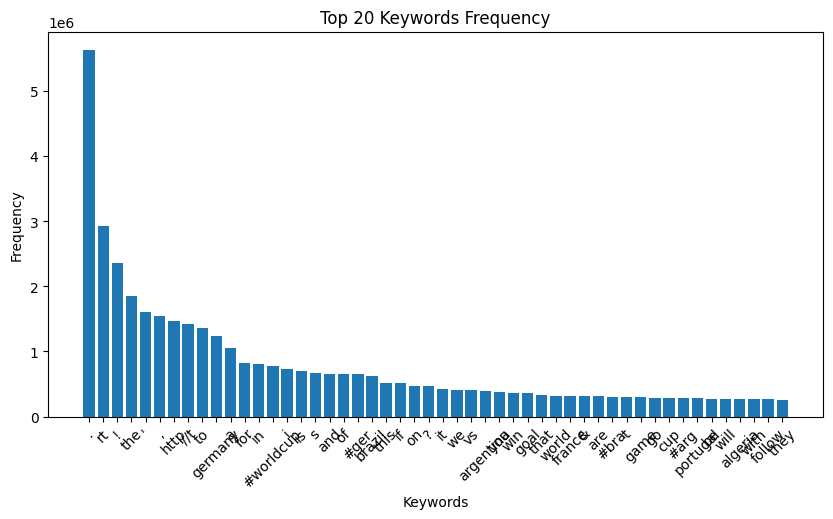

In [ ]:
print(keywords)
print(vocab)

# Plot histogram of the top 20 keywords
top_keywords = keywords[:50]
top_counts = [vocab[word] for word in top_keywords]

plt.figure(figsize=(10, 5))
plt.bar(top_keywords, top_counts)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Top 20 Keywords Frequency')
plt.xticks(rotation=45)
plt.show()

# Embedding

In [21]:
def extract_keyword_frequencies(tweets, keywords):
    feature_matrix = []
    for text in tweets:
        tokens = tokenizer(text)
        token_counts = Counter(tokens)
        frequencies = [token_counts[keyword] for keyword in keywords]
        feature_matrix.append(frequencies)
    return np.array(feature_matrix)/np.sum(np.array(feature_matrix), axis=1, keepdims=True)

In [ ]:
train, test = train_test_split(df_bis, test_size=0.3, random_state=42)
train_X = extract_keyword_frequencies(train['Tweet'], keywords)
test_X = extract_keyword_frequencies(test['Tweet'], keywords)

# Training

In [29]:
# Standardize the feature matrix
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X) # train_X -> (train_X - mean(train_X)) / std(train_X)
test_X = scaler.transform(test_X)

# Labels
train_y = np.array(train['EventType']).reshape(-1, 1)
test_y = np.array(test['EventType']).reshape(-1, 1)

# Create TensorDatasets and DataLoaders
batch_size = 64

trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [30]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [31]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [32]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

In [35]:
# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

# Plot training history
plot_history(history)


../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [0,0,0], thread: [59,0,0] Assertion `input_val >= zero && input_val <= one` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
